<h1>Modelo de <STRONG>Deep Learning</STRONG> para la proyección del precio de las acciones de <STRONG>APPLE</STRONG> en la bolsa de valores</h1>

<h2>Librerias e Importación de los datos</h2>

In [170]:
# Librerías para importar, procesar y graficar los datos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar bases de datos

#Ruta del archivo con la información semanal del precio de la accion de APPLE
Ruta = "Insumo\AAPL.US_W1.csv"

# Crear la base de datos segun la ruta
BD = pd.read_csv(Ruta, usecols = ['datetime', 'close'])
BD['datetime'] = pd.to_datetime(BD['datetime'], format='%Y-%m-%d')
BD = BD.set_index('datetime')
BD = BD.sort_index()


#Revisar la BD
BD.head(10)

,close
datetime,
1997-12-28,0.14
1998-01-04,0.16
1998-01-11,0.16
1998-01-18,0.17
1998-01-25,0.16
1998-02-01,0.16
1998-02-08,0.17
1998-02-15,0.17
1998-02-22,0.21


<h2>1. Análisis detallado de la variable tiempo</h2>
<h3>1.1. Características básicas</h3>

Veamos algunas características básicas del índice de nuestra serie (el cual contiene, precisamente, la variable tiempo):

In [178]:
# Va del 28 de Diciembre de 1997 al 07 de Enero de 2024
# Es decir 26 años
print(BD.index[0])
print(BD.index[-1])
print(BD.index[-1]-BD.index[0])

1997-12-28 00:00:00
2024-01-07 00:00:00
9506 days 00:00:00


In [181]:
# La serie tiene frecuencia semanal: por cada semana tenemos un registro o muestra
pd.infer_freq(BD.index)

'W-SUN'

<h3>1.2. Revisión del comportamiento histórico de la acción</h3>

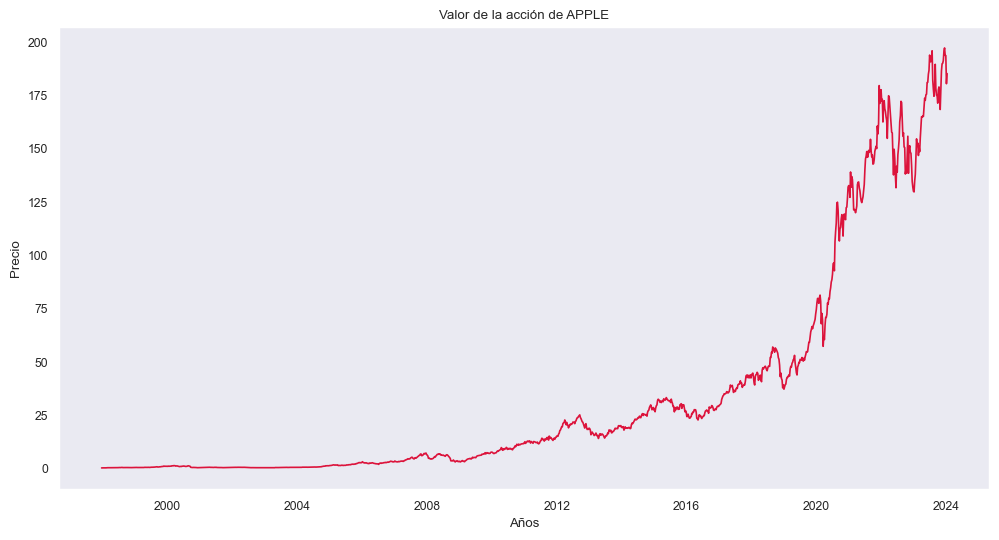

In [182]:
# Configurar el estilo
sns.set_style("dark")
sns.color_palette("rocket", as_cmap=True)
sns.set_context("paper")
plt.figure(figsize=(12, 6))

# Graficar la serie de tiempo
sns.lineplot(x='datetime', y='close', data=BD, color = "crimson")

# Configurar etiquetas y título
plt.xlabel('Años')
plt.ylabel('Precio')
plt.title('Valor de la acción de APPLE')

# Mostrar el gráfico
plt.show()

<h2>2. Procesamiento de la base de datos</h2> 
<h3>2.1. Partición de la BD en train, val, test</h3>

In [191]:
def train_val_test_split(serie, train_size, val_size, test_size):
    # Numero de filas de la serie
    N = serie.shape[0]
    
    # Numero de filas de train, val, test
    N_train = int(N * train_size)
    N_val   = int(N * val_size)
    
    #Base con la partición
    train = serie[0:N_train]
    val   = serie[N_train:N_train+N_val]
    test  = serie[N_train+N_val:]
    
    return train, val, test

# Particionar las diferentes bases de datos
BD_Train, BD_Val, BD_Test = train_val_test_split(BD, 0.9, 0.05, 0.05)

print(f'Tamaño de train: {BD_Train.shape}')
print(f'Tamaño de val: {BD_Val.shape}')
print(f'Tamaño de test: {BD_Test.shape}')

Tamaño de train: (1223, 1)
Tamaño de val: (67, 1)
Tamaño de test: (69, 1)


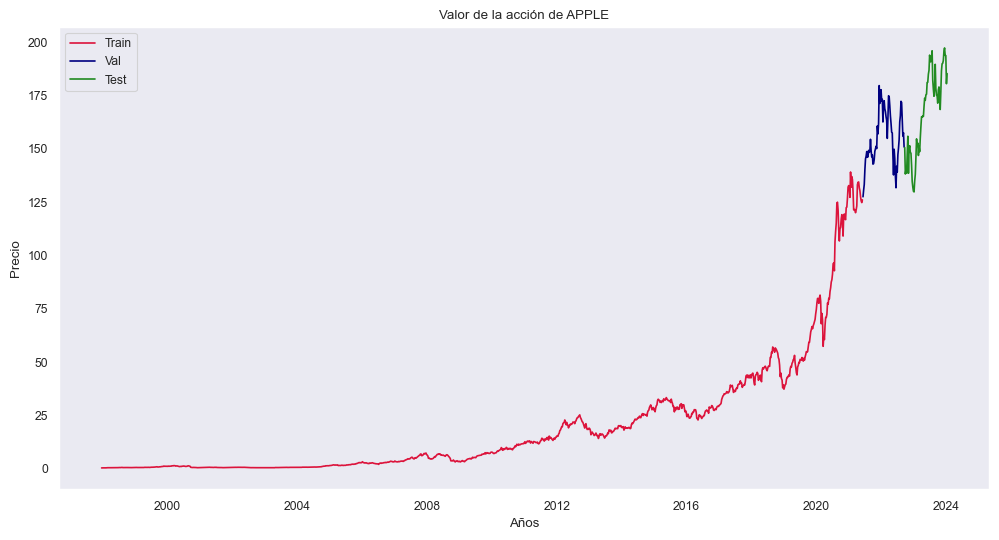

In [192]:
# Graficar cada sub BD

# Configurar el estilo
sns.set_style("dark")
sns.color_palette("rocket", as_cmap=True)
sns.set_context("paper")
plt.figure(figsize=(12, 6))

# Graficar la serie de tiempo
sns.lineplot(x='datetime', y='close', data=BD_Train, label = "Train", color = "crimson")
sns.lineplot(x='datetime', y='close', data=BD_Val, label = "Val", color = "Navy")
sns.lineplot(x='datetime', y='close', data=BD_Test, label = "Test", color = "forestgreen")

# Configurar etiquetas y título
plt.xlabel('Años')
plt.ylabel('Precio')
plt.title('Valor de la acción de APPLE')

plt.show()

<h3>2.2. Preparación de los datos</h3>

In [216]:
def create_supervised_dataset(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    
    # Verificar que array sea un arreglo de NumPy
    array = np.array(array)
    
    if array.shape[1] == 1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
        
    else: # Multivariado
        fils, cols = array.shape
    
    # Generar los arreglos
    for i in range(fils - input_length - output_length + 1):
        # Acceder a subconjuntos de filas y columnas
        X.append(array[i:i+input_length, :cols])
        Y.append(array[i+input_length:i+input_length+output_length, -1].reshape(output_length, 1))
    
    return np.array(X), np.array(Y)

# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24    # Registros de 24 semanas consecutivas a la entrada
OUTPUT_LENGTH = 1    # El modelo va a predecir 1 semana a futuro

#Transformar los datasets a la estructura de una red LSTM
X_train, y_train = create_supervised_dataset(BD_Train, INPUT_LENGTH, OUTPUT_LENGTH)
X_Val, y_Val = create_supervised_dataset(BD_Val, INPUT_LENGTH, OUTPUT_LENGTH)
X_Test, y_Test = create_supervised_dataset(BD_Test, INPUT_LENGTH, OUTPUT_LENGTH)

In [229]:
# Escalamiento de los datos
from sklearn.preprocessing import MinMaxScaler

# Función para escalar todo el dataset
def escalar_dataset(data_input):
    
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(data_input['x_tr'][:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(data_input['x_vl'][:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(data_input['x_ts'][:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(data_input['y_tr'][:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(data_input['y_vl'][:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(data_input['y_ts'][:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

# Creaar diccionario con las diferentes BD
data_in = {
    'x_tr': X_train, 'y_tr': y_train,
    'x_vl': X_Val, 'y_vl': y_Val,
    'x_ts': X_Test, 'y_ts': y_Test,
}

# Aplicar el escalado
data_s, scaler = escalar_dataset(data_in)

# Asignar las bases ya escaladas
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

<h2>3. Creación de la Red LSTM</h2>

In [247]:
#Liberias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Establecer la semilla
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()

# Parametros
N_UNITS = 128
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
Learning_rate = 5e-5
EPOCHS = 10000
BATCH_SIZE = 256

# Definición de la red
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape = INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation = 'linear'))

# Definición de la metrica del error RMSE
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = RMSprop(learning_rate = Learning_rate)

modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenar el modelo
RED_LSTM = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)


Epoch 1/10000
5/5 - 8s - loss: 0.8507 - val_loss: 1.3616 - 8s/epoch - 2s/step
Epoch 2/10000
5/5 - 1s - loss: 0.8011 - val_loss: 1.3194 - 545ms/epoch - 109ms/step
Epoch 3/10000
5/5 - 1s - loss: 0.7639 - val_loss: 1.2828 - 532ms/epoch - 106ms/step
Epoch 4/10000
5/5 - 1s - loss: 0.7299 - val_loss: 1.2483 - 591ms/epoch - 118ms/step
Epoch 5/10000
5/5 - 1s - loss: 0.6968 - val_loss: 1.2148 - 579ms/epoch - 116ms/step
Epoch 6/10000
5/5 - 1s - loss: 0.6639 - val_loss: 1.1817 - 526ms/epoch - 105ms/step
Epoch 7/10000
5/5 - 1s - loss: 0.6304 - val_loss: 1.1484 - 560ms/epoch - 112ms/step
Epoch 8/10000
5/5 - 1s - loss: 0.5959 - val_loss: 1.1149 - 571ms/epoch - 114ms/step
Epoch 9/10000
5/5 - 1s - loss: 0.5603 - val_loss: 1.0809 - 550ms/epoch - 110ms/step
Epoch 10/10000
5/5 - 1s - loss: 0.5232 - val_loss: 1.0464 - 550ms/epoch - 110ms/step
Epoch 11/10000
5/5 - 1s - loss: 0.4844 - val_loss: 1.0113 - 593ms/epoch - 119ms/step
Epoch 12/10000
5/5 - 1s - loss: 0.4435 - val_loss: 0.9754 - 506ms/epoch - 101ms/

KeyboardInterrupt: 

In [246]:
# Desempeño del modelo
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.017
  RMSE val:	 0.130
  RMSE test:	 0.144
